In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# python packages to perform Regressions
import statsmodels.api as sm
from scipy import stats

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.graphics.tsaplots import plot_pacf


from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA

from sklearn.svm import LinearSVC

import functools as ft


from IPython.display import display

In [2]:
# load data

df = pd.read_csv('../data/Preprocessed_data/df_cleaned_02.csv')

# Set the 'Date' column back to the index
# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)


df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1503 entries, 2022-07-25 to 2024-07-22
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ticker_symbol  1503 non-null   object 
 1   company_name   1503 non-null   object 
 2   Open           1503 non-null   float64
 3   High           1503 non-null   float64
 4   Low            1503 non-null   float64
 5   Close          1503 non-null   float64
 6   Adj Close      1503 non-null   float64
 7   Volume         1503 non-null   int64  
 8   Daily_Return   1500 non-null   float64
 9   30_MA          1416 non-null   float64
 10  90_MA          1236 non-null   float64
 11  RSI            1464 non-null   float64
 12  MACD           1503 non-null   float64
 13  symbol         24 non-null     object 
dtypes: float64(10), int64(1), object(3)
memory usage: 176.1+ KB


,ticker_symbol,company_name,Open,High,Low,Close,Adj Close,Volume,Daily_Return,30_MA,90_MA,RSI,MACD,symbol
Date,,,,,,,,,,,,,,
2022-07-25,OCUL,OCUL,4.37,4.410,4.179,4.26,4.26,264400,NaN,NaN,NaN,NaN,0.000000,NaN
2022-07-26,OCUL,OCUL,4.21,4.370,4.150,4.31,4.31,260500,0.011737,NaN,NaN,NaN,0.003989,NaN
2022-07-27,OCUL,OCUL,4.33,4.480,4.270,4.45,4.45,284800,0.032483,NaN,NaN,NaN,0.018236,NaN
2022-07-28,OCUL,OCUL,4.47,4.480,4.200,4.30,4.30,299900,-0.033708,NaN,NaN,NaN,0.017225,NaN
2022-07-29,OCUL,OCUL,4.32,4.485,4.190,4.48,4.48,511900,0.041860,NaN,NaN,NaN,0.030596,NaN


### Computing percent changes and differences of time series

Notice that the first row of the return series is NaN. Each return is computed from two prices, so there is one less return than price. To delete the first row of NaN's, use the pandas method "dropna". 

In [3]:
# Use pct_change() method to convert prices to returns

df['Close'].pct_change()


Date
2022-07-25         NaN
2022-07-26    0.011737
2022-07-27    0.032483
2022-07-28   -0.033708
2022-07-29    0.041860
                ...   
2024-07-16   -0.039063
2024-07-17   -0.019164
2024-07-18   -0.014802
2024-07-19   -0.051082
2024-07-22    0.025966
Name: Close, Length: 1503, dtype: float64

In [4]:
df['Close'].diff()

Date
2022-07-25         NaN
2022-07-26    0.050000
2022-07-27    0.140000
2022-07-28   -0.150000
2022-07-29    0.180000
                ...   
2024-07-16   -0.700001
2024-07-17   -0.330000
2024-07-18   -0.250000
2024-07-19   -0.849999
2024-07-22    0.410001
Name: Close, Length: 1503, dtype: float64

### Compute correlation of Series

In [5]:
df.groupby(['ticker_symbol'])['Close'].mean()

ticker_symbol
OCUL     5.000669
SLDB     6.633493
URGN    12.412595
Name: Close, dtype: float64

In [6]:
df_OCUL_ = df[df['ticker_symbol'] == 'OCUL'].copy()
df_SLDB_ = df[df['ticker_symbol'] == 'SLDB'].copy()
df_URGN_ = df[df['ticker_symbol'] == 'URGN'].copy()
df_OCUL_.info()
df_SLDB_.info()
df_URGN_.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 501 entries, 2022-07-25 to 2024-07-22
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ticker_symbol  501 non-null    object 
 1   company_name   501 non-null    object 
 2   Open           501 non-null    float64
 3   High           501 non-null    float64
 4   Low            501 non-null    float64
 5   Close          501 non-null    float64
 6   Adj Close      501 non-null    float64
 7   Volume         501 non-null    int64  
 8   Daily_Return   500 non-null    float64
 9   30_MA          472 non-null    float64
 10  90_MA          412 non-null    float64
 11  RSI            488 non-null    float64
 12  MACD           501 non-null    float64
 13  symbol         8 non-null      object 
dtypes: float64(10), int64(1), object(3)
memory usage: 58.7+ KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 501 entries, 2022-07-25 to 2024-07-22
Data columns (tot

In [7]:
df_OCUL_.columns

Index(['ticker_symbol', 'company_name', 'Open', 'High', 'Low', 'Close',
       'Adj Close', 'Volume', 'Daily_Return', '30_MA', '90_MA', 'RSI', 'MACD',
       'symbol'],
      dtype='object')

In [8]:
df_OCUL_.rename({'Close': 'OCUL_Close', 'Daily_Return': 'OCUL_ret'}, axis=1, inplace=True)
df_SLDB_.rename({'Close': 'SLDB_Close', 'Daily_Return': 'SLDB_ret'}, axis=1, inplace=True)
df_URGN_.rename({'Close': 'URGN_Close', 'Daily_Return': 'URGN_ret'}, axis=1, inplace=True)
df_OCUL_.columns

Index(['ticker_symbol', 'company_name', 'Open', 'High', 'Low', 'OCUL_Close',
       'Adj Close', 'Volume', 'OCUL_ret', '30_MA', '90_MA', 'RSI', 'MACD',
       'symbol'],
      dtype='object')

In [9]:
df_OCUL = df_OCUL_[['OCUL_Close','OCUL_ret']].copy()
df_SLDB = df_SLDB_[['SLDB_Close','SLDB_ret']].copy()
df_URGN = df_URGN_[['URGN_Close','URGN_ret']].copy()

In [10]:
# Correlation of levels (stock prices)

print(df_OCUL['OCUL_Close'].corr(df_SLDB['SLDB_Close']))
print(df_OCUL['OCUL_Close'].corr(df_URGN['URGN_Close']))
print(df_SLDB['SLDB_Close'].corr(df_URGN['URGN_Close']))




0.6482834070098537
0.28468242015504375
-0.06522528121029898


In [11]:
print(df_OCUL['OCUL_Close'].autocorr())
print(df_SLDB['SLDB_Close'].autocorr())
print(df_URGN['URGN_Close'].autocorr())


0.9878971062550923
0.9907432385689124
0.9779583709308248


In [12]:
# When you look at the correlation of say, two stocks, you should look at the correlation of their *returns*, 
# not their levels, to avoid spurious correlation

return_OCUL = df_OCUL['OCUL_Close'].pct_change()
return_SLDB = df_SLDB['SLDB_Close'].pct_change()
return_URGN = df_URGN['URGN_Close'].pct_change()

In [13]:
# Correlation of percent changes (returns)

print(return_OCUL.corr(return_SLDB))
print(return_OCUL.corr(return_URGN))
print(return_SLDB.corr(return_URGN))

0.20382714248754163
0.11857297260553108
0.08648675688474469


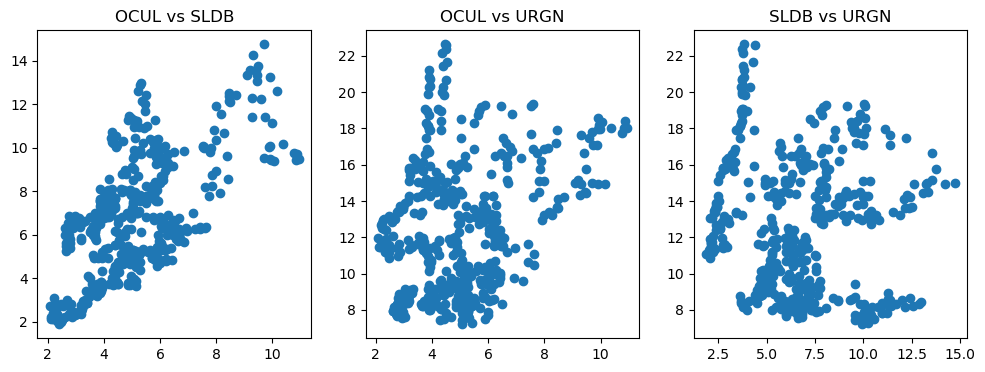

In [14]:
# Visualize Correlation with Scatter plot


# Create a 1x3 grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot scatter data for each subplot
axs[0].scatter(df_OCUL['OCUL_Close'], df_SLDB['SLDB_Close'])  # Scatter plot 1 data
axs[0].set_title("OCUL vs SLDB")

axs[1].scatter(df_OCUL['OCUL_Close'], df_URGN['URGN_Close'])  # Scatter plot 2 data
axs[1].set_title("OCUL vs URGN")

axs[2].scatter(df_SLDB['SLDB_Close'], df_URGN['URGN_Close'])  # Scatter plot 3 data
axs[2].set_title("SLDB vs URGN")

plt.show()

### Simple Linear Regressions - time series analysis

A simple linear regression finds the slope, beta, and intercept, alpha, of a line that's the best fit between a dependent variable, y, and an independent variable, x. The x's and y's can be two time series.

A linear regression is also known as Ordinary Least Squares, or OLS, because it minimizes the sum of the squared distances between the data points and the regression line.

In [15]:
sm.OLS(df_OCUL['OCUL_Close'], df_SLDB['SLDB_Close']).fit()

In [16]:
stats.linregress(df_OCUL['OCUL_Close'], df_SLDB['SLDB_Close'])

LinregressResult(slope=0.9660909550339072, intercept=1.8023922669163879, rvalue=0.6482834070098535, pvalue=4.616292551928441e-61, stderr=0.050794326885850345, intercept_stderr=0.27021120315302516)

I need to add a column of ones as a dependent, right hand side variable. The reason I have to do this is because the regression function assumes that if there is no constant column, then I want to run the regression without an intercept. By adding a column of ones, statsmodels will compute the regression coefficient of that column as well, which can be interpreted as the intercept of the line.

The statsmodels method "add constant" is a simple way to add a constant.

The first argument of the statsmodel regression is the series that represents the dependent variable, y, and the next argument contains the independent variable or variables. In this case, the dependent variable is the OCUL returns and the independent variables are the constant and SLDB returns. The method "fit" runs the regression and results are saved in a class instance called results.

In [17]:
df_3 = pd.concat([df_OCUL, df_SLDB, df_URGN], axis=1)
df_3.head()

,OCUL_Close,OCUL_ret,SLDB_Close,SLDB_ret,URGN_Close,URGN_ret
Date,,,,,,
2022-07-25,4.26,NaN,10.440,NaN,8.14,NaN
2022-07-26,4.31,0.011737,10.215,-0.021552,8.06,-0.009828
2022-07-27,4.45,0.032483,10.050,-0.016153,8.32,0.032258
2022-07-28,4.30,-0.033708,10.740,0.068657,8.16,-0.019231
2022-07-29,4.48,0.041860,10.125,-0.057263,7.84,-0.039216


In [18]:
df_3 = sm.add_constant(df_3)  # this automatically adds a column of 1's named const
df_3.head()

,const,OCUL_Close,OCUL_ret,SLDB_Close,SLDB_ret,URGN_Close,URGN_ret
Date,,,,,,,
2022-07-25,1.0,4.26,NaN,10.440,NaN,8.14,NaN
2022-07-26,1.0,4.31,0.011737,10.215,-0.021552,8.06,-0.009828
2022-07-27,1.0,4.45,0.032483,10.050,-0.016153,8.32,0.032258
2022-07-28,1.0,4.30,-0.033708,10.740,0.068657,8.16,-0.019231
2022-07-29,1.0,4.48,0.041860,10.125,-0.057263,7.84,-0.039216


Notice that the first row of the return series is NaN. Each return is computed from two prices, so there is one less return than price. To delete the first row of NaN's, use the pandas method "dropna". 

In [19]:
df_3 = df_3.dropna()
df_3.head()

,const,OCUL_Close,OCUL_ret,SLDB_Close,SLDB_ret,URGN_Close,URGN_ret
Date,,,,,,,
2022-07-26,1.0,4.31,0.011737,10.215,-0.021552,8.06,-0.009828
2022-07-27,1.0,4.45,0.032483,10.050,-0.016153,8.32,0.032258
2022-07-28,1.0,4.30,-0.033708,10.740,0.068657,8.16,-0.019231
2022-07-29,1.0,4.48,0.041860,10.125,-0.057263,7.84,-0.039216
2022-08-01,1.0,4.29,-0.042411,10.260,0.013333,7.44,-0.051020


In [20]:
# Run the regression

results = sm.OLS(df_3['OCUL_ret'],df_3[['const','SLDB_ret']]).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               OCUL_ret   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     21.59
Date:                Fri, 26 Jul 2024   Prob (F-statistic):           4.34e-06
Time:                        20:09:35   Log-Likelihood:                 741.19
No. Observations:                 500   AIC:                            -1478.
Df Residuals:                     498   BIC:                            -1470.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.002      1.018      0.309      -0.002       0.007
SLDB_ret       0.1883      0.041      4.646      0.000       0.109       0.268
==============================================================================
Omnibus:                      148.460   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1027.104
Skew:                           1.103   Prob(JB):                    9.27e-224
Kurtosis:                       9.666   Cond. No.                         16.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

    The intercept is 0.0025 (also referred to as beta), and the slope is 0.1883

In [21]:
print(results.params.iloc[0])   # the intercept
print(results.params.iloc[1])   # the slope

0.0025085146806698073
0.18827591653655157


In [22]:
# Another statistic to take note of is the R-Squared statistic (correaltion) which is 0.042. 

# This shows OCUL and SLDB are not correlated



### Autocorrelation

Autocorrelation is the correlation of a single time series with a lagged copy of itself. It's also called "serial correlation". Often, when we refer to a series's autocorrelation, we mean the "lag-one" autocorrelation. So when using daily data, for example, the autocorrelation would be the correlation of the series with the same series lagged by one day.

What does it mean when a series has a positive or negative autocorrelation? With financial time series, when returns have a negative autocorrelation, we say it is "mean reverting".

Alternatively, if a series has positive autocorrelation, we say it is "trend-following".

Since stocks have historically had negative autocorrelation over horizons of about a week, one popular strategy is to buy stocks that have dropped over the last week and sell stocks that have gone up. 

In [23]:
#  The "rule" argument indicates the desired frequency. 'W' stands for weekly, M' stands for monthly. You can use any number of functions 
#  after resample. Here we used last for the last date of the period. But you could use first date of the period, 
# or even an average over the period. 

df_3_weekly = df_3.resample(rule='W').last()
autocorrelation_OCUL = df_3_weekly['OCUL_ret'].autocorr()
autocorrelation_SLDB = df_3_weekly['SLDB_ret'].autocorr()
autocorrelation_URGN = df_3_weekly['URGN_ret'].autocorr()
print("The autocorrelation_OCUL for weekly frequency is: ", autocorrelation_OCUL)
print("The autocorrelation_SLDBL for weekly frequency is: ", autocorrelation_SLDB)
print("The autocorrelation_URGN for weekly frequency is: ", autocorrelation_URGN)


The autocorrelation_OCUL for weekly frequency is:  0.07456910092830552
The autocorrelation_SLDBL for weekly frequency is:  0.04916164029942228
The autocorrelation_URGN for weekly frequency is:  -0.07335996146896823


In [24]:
df_3_monthly = df_3.resample(rule='ME').last()
autocorrelation_OCUL = df_3_monthly['OCUL_ret'].autocorr()
autocorrelation_SLDB = df_3_monthly['SLDB_ret'].autocorr()
autocorrelation_URGN = df_3_monthly['URGN_ret'].autocorr()
print("The autocorrelation_OCUL for monthly frequency is: ", autocorrelation_OCUL)
print("The autocorrelation_SLDBL for monthly frequency is: ", autocorrelation_SLDB)
print("The autocorrelation_URGN for monthly frequency is: ", autocorrelation_URGN)



The autocorrelation_OCUL for monthly frequency is:  -0.04058287412161152
The autocorrelation_SLDBL for monthly frequency is:  0.21287438846810985
The autocorrelation_URGN for monthly frequency is:  -0.11325764651424772


One puzzling anomaly with stocks is that investors tend to overreact to news. Following large jumps, either up or down, stock prices tend to reverse. This is described as mean reversion in stock prices: prices tend to bounce back, or revert, towards previous levels after large moves, which are observed over time horizons of about a week. A more mathematical way to describe mean reversion is to say that stock returns are negatively autocorrelated.

### ACF - Autocorrelation Function

shows not only the lag-one autocorrelation as shown before, but the entire autocorrelation function for different lags. 

**Any significant non-zero autocorrelations implies that the series can be forecast from the past.**

This autocorrelation function implies that you can forecast the next value of the series from the last two values, since the lag-one and lag-two autocorrelations differ from zero.

The ACF can also be useful for selecting a parsimonious model for fitting the data. 

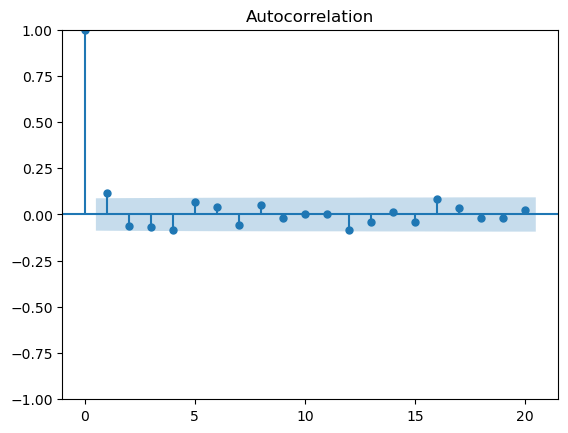

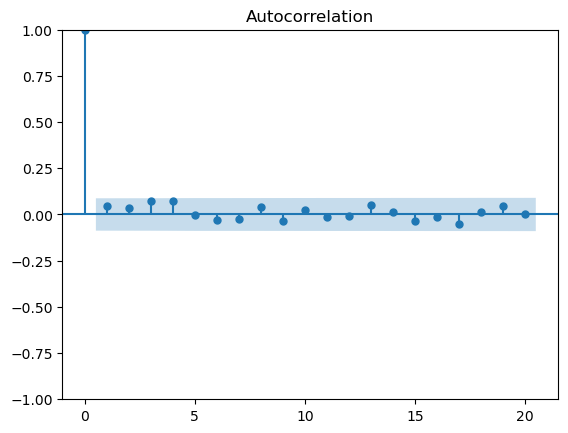

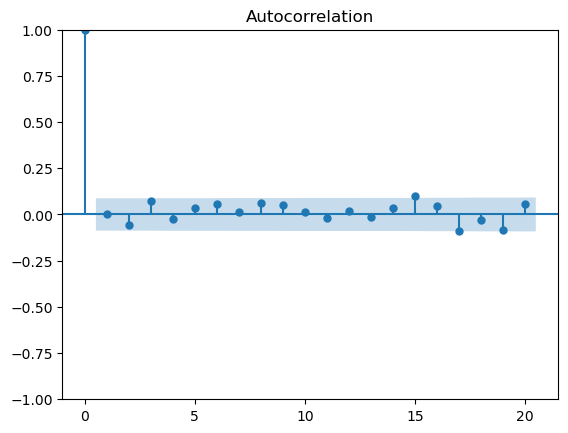

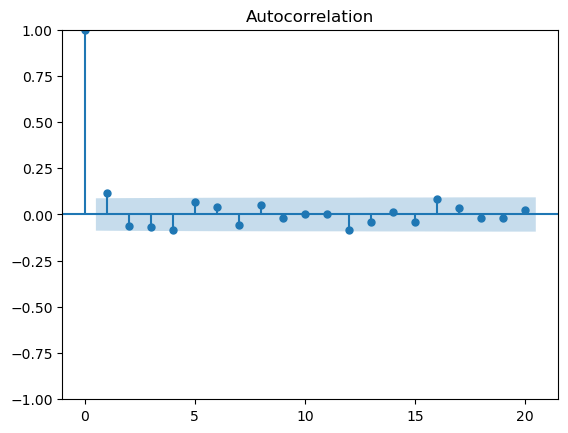

In [25]:
# Plot the ACF:
plot_acf(df_3['OCUL_ret'], lags=20, alpha=0.05)
plot_acf(df_3['SLDB_ret'], lags=20, alpha=0.05)
plot_acf(df_3['URGN_ret'], lags=20, alpha=0.05)

# Here is the ACF plot that contains confidence intervals for each lag, which is the blue region in the figure.


the argument alpha determines the width of the confidence intervals. For example, if alpha equals 0.05, that means that if the true autocorrelation at that lag is zero, there is only a 5% chance the sample autocorrelation will fall outside that window. You will get a wider confidence interval if you set alpha lower, or if you have fewer observations

In [26]:
print(acf(df_3['OCUL_ret']))
print(acf(df_3['SLDB_ret']))
print(acf(df_3['URGN_ret']))

[ 1.          0.04520688  0.0341954   0.07067941  0.07039252 -0.00400201
 -0.02886625 -0.02480681  0.04014138 -0.03268178  0.02473673 -0.01205992
 -0.00676418  0.05301674  0.01469535 -0.03455325 -0.01142903 -0.0520083
  0.01234904  0.04377457  0.00463311  0.06052887  0.03916108 -0.00420329
 -0.03098763  0.03064115 -0.01382024]
[ 1.          0.00195805 -0.05463287  0.07353161 -0.02332494  0.03308882
  0.05556399  0.0160324   0.06214353  0.05163866  0.01476571 -0.01892755
  0.01894434 -0.01525401  0.03432456  0.10194542  0.0482673  -0.09164013
 -0.03248527 -0.08243809  0.05591812  0.2521279   0.02351034 -0.03112066
  0.07377504  0.04872854  0.05730687]
[ 1.00000000e+00  1.13643886e-01 -6.41449558e-02 -6.86331144e-02
 -8.48023471e-02  6.74018053e-02  3.82600726e-02 -5.65095128e-02
  5.33456429e-02 -1.98948347e-02  9.99981281e-04  3.45192512e-03
 -8.13509790e-02 -4.28082023e-02  1.14802839e-02 -4.08291404e-02
  8.27753364e-02  3.25825324e-02 -2.08232035e-02 -2.02001639e-02
  2.16447683e-02

### White Noise

is a series with mean that is constant with time, a variance that is also constant with time, and zero autocorrelation at all lags. Unfortunately, for white noise, we cannot forecast future observations based on the past - autocorrelations at all lags are zero

### Random Walk

- Today's price is equal to yesterday's price plus some noise.  
- The change in price of a random walk is just White Noise. 
- If stock *prices* follow a random walk, then stock *returns* are White Noise. You can't forecast a random walk. The best guess for tomorrow's price is simply today's price.

### Statistical Test for Random Walk

To test whether a series like stock prices follows a random walk, you can regress current prices on lagged prices. 
- If the slope coefficient, beta, is not significantly different from one, then we cannot reject the null hypothesis that the series is a random walk.
- However, if the slope coefficient is significantly less than one, then we can reject the null hypothesis that the series is a random walk.

*An identical way to do that test is to regress the difference in prices on the lagged price, and instead of testing whether the slope coefficient is 1, now we test whether it is zero.*



This is called the **"Dickey-Fuller"** test. If you add more lagged prices on the right hand side, then it's called the **Augmented Dickey-Fuller** test, **ADF**.



*Note:*


With the ADF test, the "null hypothesis" (the hypothesis that we either reject or fail to reject) 
is that the series follows a random walk. Therefore, a low p-value (say less than 5%) means 
we can reject the null hypothesis that the series is a random walk.

In [27]:
results_adf_OCUL=adfuller(df_3['OCUL_Close'])
print(results_adf_OCUL)
print('The p-value of the test on OCUL stock prices is: ' + str(results_adf_OCUL[1]))


(-2.145448719627522, 0.22663626819274602, 4, 495, {'1%': -3.4436298692815304, '5%': -2.867396599893435, '10%': -2.5698893429241916}, 147.3080760634134)
The p-value of the test on OCUL stock prices is: 0.22663626819274602


**p-value for OCUL stock prices is 0.22 > 0.05, therefore we reject the null hypothesis that the series is a random walk**

In [28]:
results_adf_SLDB=adfuller(df_3['SLDB_Close'])
print(results_adf_SLDB)
print('The p-value of the test on SLDB stock prices is: ' + str(results_adf_SLDB[1]))

(-1.7979263131275376, 0.3814917065277924, 3, 496, {'1%': -3.4436029548776395, '5%': -2.867384756137026, '10%': -2.5698830308597813}, 390.5882193446198)
The p-value of the test on SLDB stock prices is: 0.3814917065277924


**p-value for SLDB stock prices is 0.38 > 0.05, therefore we reject the null hypothesis that the series is a random walk**

In [29]:
results_adf_URGN=adfuller(df_3['URGN_Close'])
print(results_adf_URGN)
print('The p-value of the test on URGN stock prices is: ' + str(results_adf_URGN[1]))

(-2.348538418845937, 0.15679065170272988, 8, 491, {'1%': -3.4437386290417082, '5%': -2.867444458865948, '10%': -2.5699148492415413}, 1076.0895111109712)
The p-value of the test on URGN stock prices is: 0.15679065170272988


**p-value for URGN stock prices is 0.15 > 0.05, therefore we reject the null hypothesis that the series is a random walk**

*Whereas stock returns are often modeled as white noise, stock prices closely follow a random walk. In other words, today's price is yesterday's price plus some random noise.*

*Many time series, like stock prices, are random walks but tend to drift up over time.*

### Stationarity

means that the mean, variance, and autocorrelations of the observations do not depend on time. 

If a process is not stationary, then it becomes difficult to model. Modeling involves estimating a set of parameters, and if a process is not stationary, and the parameters are different at each point in time, then there are too many parameters to estimate. You may end up having more parameters than actual data! So stationarity is necessary for a parsimonious model, one with a smaller set of parameters to estimate.

A random walk is a common type of non-stationary series. The variance grows with time. For example, if stock prices are a random walk, then the uncertainty about prices tomorrow is much less than the uncertainty 10 years from now.

### Transforming Nonstationary Series Into Stationary Series

Many non-stationary series can be made stationary through a simple transformation. A Random Walk is a non-stationary series, but if you take the first differences, the new series is White Noise, which is stationary. 

For seasonal adjustments, instead of taking first differences, you will take differences with a lag corresponding to the periodicity, which is 4 for quarterly earnigs for instance.

Sometimes, you may need to make two transformations.

# Autoregressive model - AR

or AR model, today's value equals a mean plus a fraction phi of yesterday's value, plus noise. Since there is only one lagged value on the right hand side, this is called an AR model of order 1, or simply an AR(1) model. If the AR parameter, phi, is one, then the process is a random walk. If phi is zero, then the process is white noise. In order for the process to be stable and stationary, phi has to be between -1 and +1.



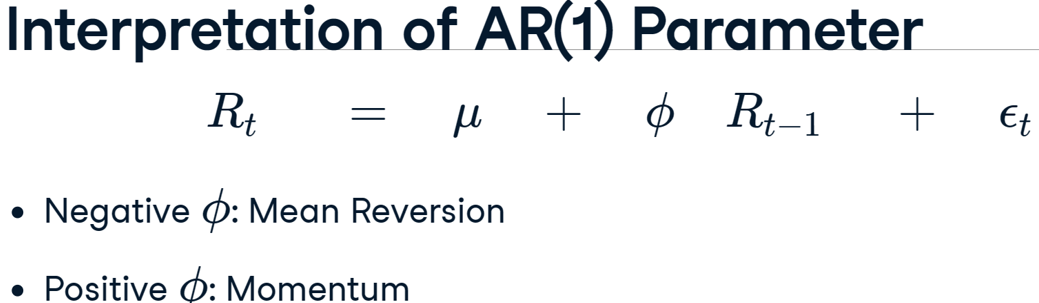

- *suppose R_t is a time series of stock returns. If phi is negative, then a positive return last period, at time t-1, implies that this period's return is more likely to be negative. This is referred to as **"mean reversion"**.*

- *On the other hand, if phi is positive, then a positive return last period implies that this period's return is expected to be positive. This is referred to as **"momentum"**.*

. The model can be extended to include more lagged values and more phi parameters. Here we show an AR(1), an AR(2), and an AR(3).

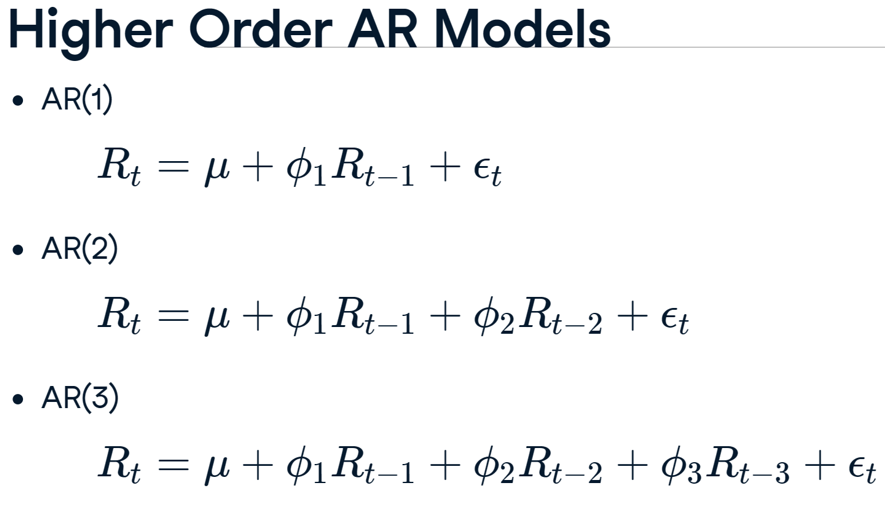

There are a few conventions when using the arima_process module that require some explanation. First, these routines were made very generally to handle both AR and MA models. For now, just ignore the MA part. Second, when inputting the coefficients, you must include the zero-lag coefficient of 1, and the sign of the other coefficients is opposite what we have been using (to be consistent with the time series literature in signal processing). 

For example, for an AR(1) process with 𝜙=0.9, the array representing the AR parameters would be ar = np.array([1, -0.9])

In [30]:
# With parameters ar1 and ma1, create an instance of the class ArmaProcess(ar,ma) called AR_object1.

### Estimating and Forecasting an AR model

Create an instance of ARMA class called *mod*

mod = ARIMA(data), order=(p,d,q)

with the arguments being the data that you're trying to fit, and p the order of the model. The order (1,0,0) means you're fitting the data to an AR(1) model. An order (2,0,0) would mean you're fitting the data to an AR(2) model. The middle number, d, relates to whether you take first differences of the data to make the time series stationary, the third number, q, is the MA part.

If the date column in df was read in as a string, you will have to convert the index of dates from a string to a datetime object using the pandas method "to_datetime

In [31]:
print(type(df_3.index))

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [32]:
# to convert index to datetime use:           df_3.index=pd.to_datetime(df_3.index)

In [33]:
df_3_daily=df_3.resample(rule='D').last()   # dataframe must be resampled to be able to use it in a forecast model. 

In [34]:
mod = ARIMA(df_3_daily['OCUL_Close'], order=(1,0,0))
result_AR_OCUL = mod.fit()
print(result_AR_OCUL.summary())

                               SARIMAX Results                                
Dep. Variable:             OCUL_Close   No. Observations:                  728
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -105.032
Date:                Fri, 26 Jul 2024   AIC                            216.064
Time:                        20:09:35   BIC                            229.835
Sample:                    07-26-2022   HQIC                           221.378
                         - 07-22-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2434      1.179      4.446      0.000       2.932       7.555
ar.L1          0.9901      0.006    158.290      0.000       0.978       1.002
sigma2         0.0696      0.002     43.872      0.0

In [35]:
mod = ARIMA(df_3_daily['SLDB_Close'], order=(1,0,0))
result_AR_SLDB = mod.fit()
print(result_AR_SLDB.summary())

                               SARIMAX Results                                
Dep. Variable:             SLDB_Close   No. Observations:                  728
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -238.061
Date:                Fri, 26 Jul 2024   AIC                            482.123
Time:                        20:09:35   BIC                            495.894
Sample:                    07-26-2022   HQIC                           487.437
                         - 07-22-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.3478      1.628      4.512      0.000       4.156      10.540
ar.L1          0.9919      0.005    208.424      0.000       0.983       1.001
sigma2         0.1183      0.004     32.545      0.0

In [36]:
mod = ARIMA(df_3_daily['URGN_Close'], order=(1,0,0))
result_AR_URGN = mod.fit()
print(result_AR_URGN.summary())

                               SARIMAX Results                                
Dep. Variable:             URGN_Close   No. Observations:                  728
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -603.930
Date:                Fri, 26 Jul 2024   AIC                           1213.860
Time:                        20:09:35   BIC                           1227.631
Sample:                    07-26-2022   HQIC                          1219.173
                         - 07-22-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.4117      1.762      7.043      0.000       8.958      15.866
ar.L1          0.9803      0.008    115.428      0.000       0.964       0.997
sigma2         0.5149      0.008     61.999      0.0

In [37]:
# want to see the coefficients rather than the entire regression output, you can use the params property, which returns 
# an array of the fitted coefficients, mu and phi in this case.
print('OCUL params are:')
print(result_AR_OCUL.params)
print()
print('SLDB params are:')
print(result_AR_SLDB.params)
print()
print('URGN params are:')
print(result_AR_URGN.params)


OCUL params are:
const     5.243436
ar.L1     0.990099
sigma2    0.069584
dtype: float64

SLDB params are:
const     7.347788
ar.L1     0.991944
sigma2    0.118323
dtype: float64

URGN params are:
const     12.411746
ar.L1      0.980327
sigma2     0.514896
dtype: float64


### Forecasting With an AR Model

To plot forecasts, both in-sample and out-of-sample, I use statsmodels function called plot_predict. The first argument in the plot_predict function is the result from the fitted model I just defined above. I also give plot_predict the starting and ending data points for forecasting. If the index of the data is a DatetimeIndex object as it is here, I can pick dates for the start and end date. The alpha argument sets the darkness of the shaded confidence interval region, and if I don't want a confidence interval at all, I set alpha equal to None. I also need to set ax equal to ax so that the data and the predictions are on the same axes. In this plot, the confidence interval gets wider the farther out the forecast is.

In [38]:
df_3_daily.index

DatetimeIndex(['2022-07-26', '2022-07-27', '2022-07-28', '2022-07-29',
               '2022-07-30', '2022-07-31', '2022-08-01', '2022-08-02',
               '2022-08-03', '2022-08-04',
               ...
               '2024-07-13', '2024-07-14', '2024-07-15', '2024-07-16',
               '2024-07-17', '2024-07-18', '2024-07-19', '2024-07-20',
               '2024-07-21', '2024-07-22'],
              dtype='datetime64[ns]', name='Date', length=728, freq='D')

In [39]:
df_3.index

DatetimeIndex(['2022-07-26', '2022-07-27', '2022-07-28', '2022-07-29',
               '2022-08-01', '2022-08-02', '2022-08-03', '2022-08-04',
               '2022-08-05', '2022-08-08',
               ...
               '2024-07-09', '2024-07-10', '2024-07-11', '2024-07-12',
               '2024-07-15', '2024-07-16', '2024-07-17', '2024-07-18',
               '2024-07-19', '2024-07-22'],
              dtype='datetime64[ns]', name='Date', length=500, freq=None)

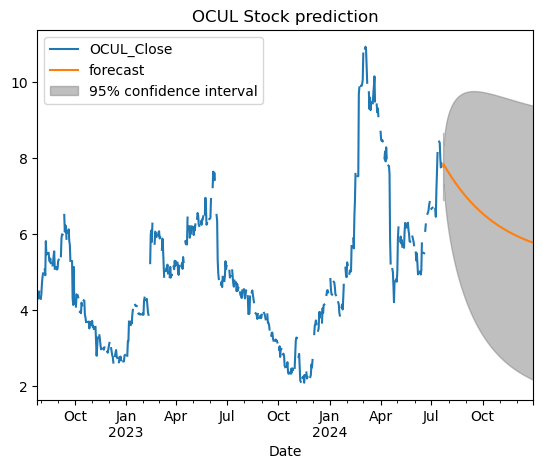

In [40]:
fig, ax = plt.subplots()
df_3_daily['OCUL_Close'].plot(ax=ax)
plot_predict(result_AR_OCUL, start='2024-07-22', end='2024-12-31', ax=ax)
plt.title('OCUL Stock prediction')
plt.show()


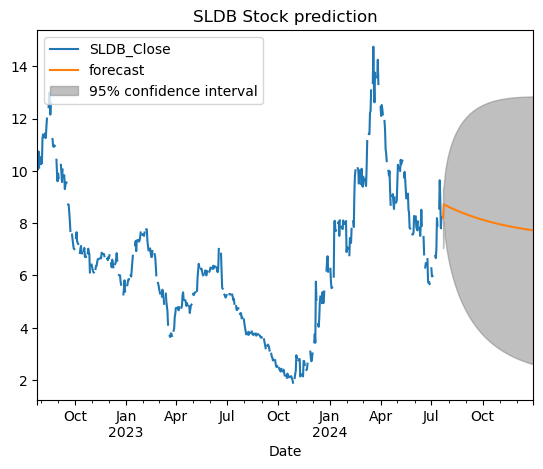

In [41]:
fig, ax = plt.subplots()
df_3_daily['SLDB_Close'].plot(ax=ax)
plot_predict(result_AR_SLDB, start='2024-07-22', end='2024-12-31', ax=ax)
plt.title('SLDB Stock prediction')
plt.show()

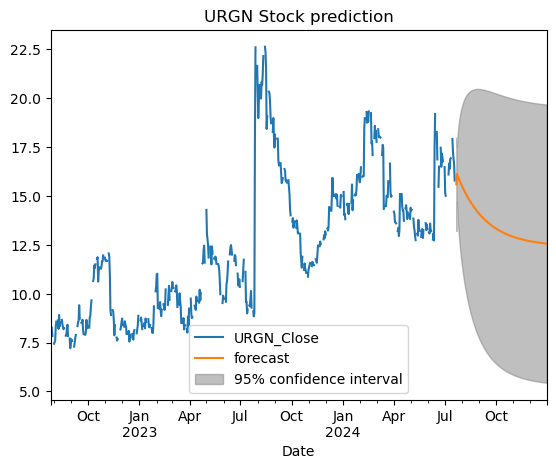

In [42]:
fig, ax = plt.subplots()
df_3_daily['URGN_Close'].plot(ax=ax)
plot_predict(result_AR_URGN, start='2024-07-22', end='2024-12-31', ax=ax)
plt.title('URGN Stock prediction')
plt.show()

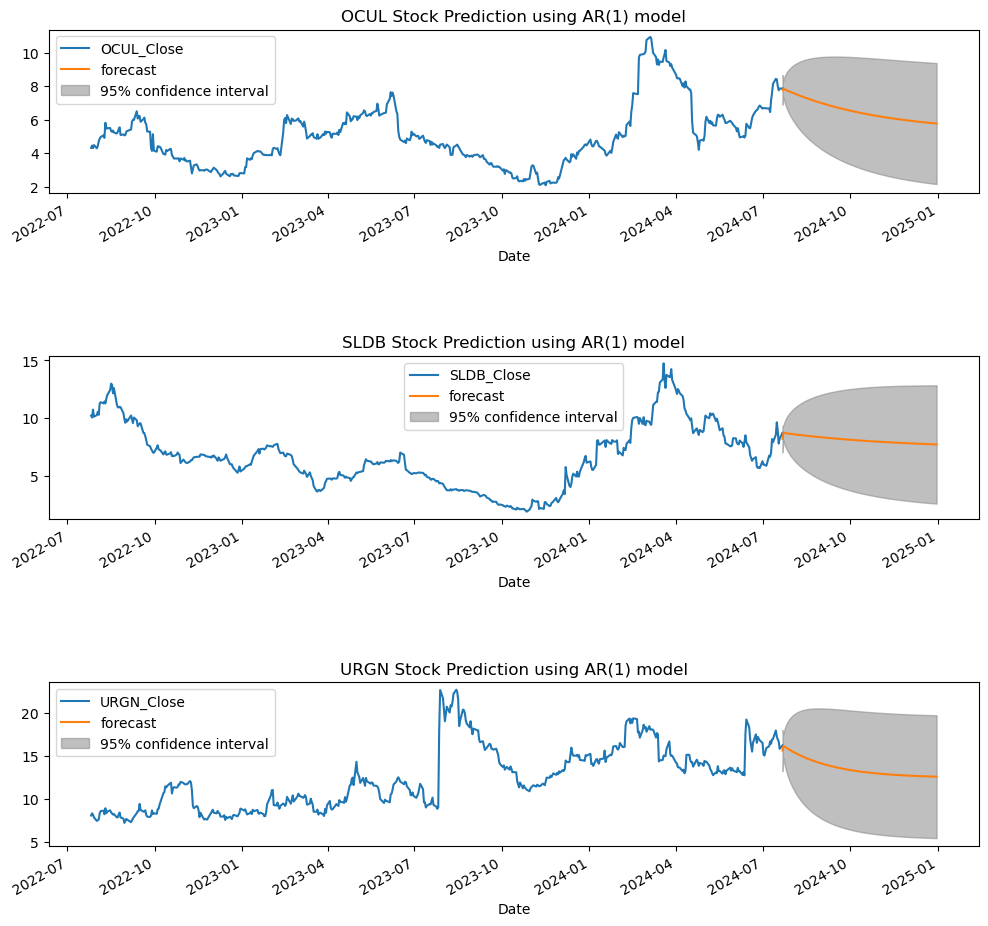

In [43]:
# Create a 1x3 grid of subplots for Stock prediction


fig, axes = plt.subplots(3,1, figsize = (12,12), gridspec_kw={'wspace': 1, 'hspace': 1})


fig= df_3['OCUL_Close'].plot(ax=axes[0])
fig=plot_predict(result_AR_OCUL, start='2024-07-22', end='2024-12-31', ax=axes[0])
axes[0].set_title('OCUL Stock Prediction using AR(1) model')

fig=df_3['SLDB_Close'].plot(ax=axes[1])
fig=plot_predict(result_AR_SLDB, start='2024-07-22', end='2024-12-31', ax=axes[1])
axes[1].set_title('SLDB Stock Prediction using AR(1) model')

fig=df_3['URGN_Close'].plot(ax=axes[2])
fig=plot_predict(result_AR_URGN, start='2024-07-22', end='2024-12-31', ax=axes[2])
axes[2].set_title('URGN Stock Prediction using AR(1) model')


plt.show()

### Choosing the right model

The order of an AR(p) model will usually be unknown

### Identifying the Order of an AR Model

There are two techniques that can help determine the order of the AR model: 

    -The Partial Autocorrelation Function PACF
    -and the Information Criteria
    
   The **Partial Autocorrelation Function PACF** measures the incremental benefit of adding another lag. The coefficients in the red boxes represent the values of the partial autocorrelation function for different lags. For example, in the bottom row, the coefficient in the red box, phi 4,4, is the lag-4 value of the Partial Autocorrelation Function, and it represents how significant adding a fourth lag is when you already have three lags.
   
   The more parameters in a model, the better the model will fit the data. But this can lead to overfitting of the data. The **information criteria** adjusts the goodness-of-fit of a model by imposing a penalty based on the number of parameters used. Two common adjusted goodness-of-fit measures are called the Akaike Information Criterion **AIC** and the Bayesian Information Criterion **BIC**.

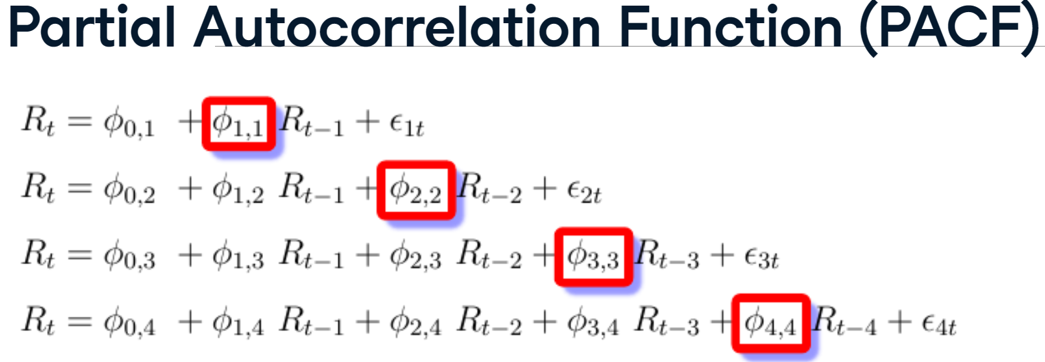

plot_pacf(x, lags=20, alpha=0.05) is the statsmodels function for plotting the partial autocorrelation function. 

The arguments are the same as that of the plot_acf module that I used earlier. The input x is a series or array. The argument lags indicates how many lags of the partial autocorrelation function will be plotted. And the alpha argument sets the width of the confidence interval.

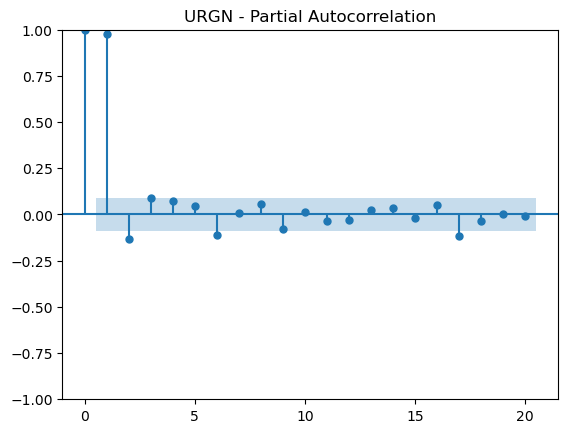

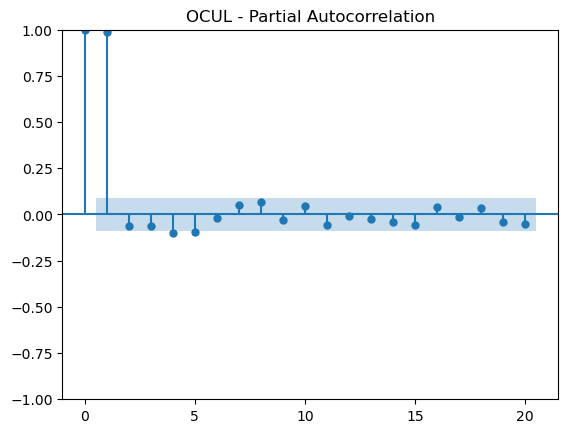

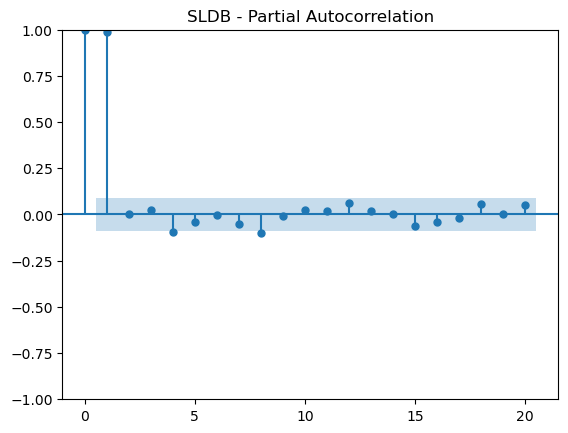

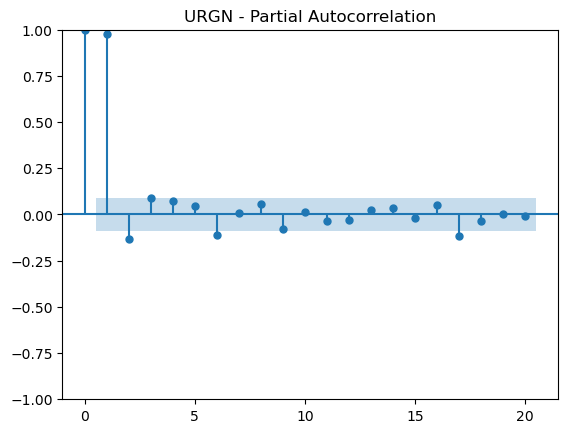

In [44]:
plot_pacf(df_3['OCUL_Close'], lags=20, alpha=0.05, title='OCUL - Partial Autocorrelation')
plot_pacf(df_3['SLDB_Close'], lags=20, alpha=0.05, title='SLDB - Partial Autocorrelation')
plot_pacf(df_3['URGN_Close'], lags=20, alpha=0.05, title='URGN - Partial Autocorrelation')



    -for an AR(1) model, only the lag-1 PACF is significantly different from zero.

    -the number of significant lags for the PACF indicate the order of the AR model

### Getting Information Criteria from statsmodels

Follow the same procedure from before to fit the data to a model AR(1). I can get the full output using summary or just the AR parameters using the params attribute. 

I can also get the **AIC** or **BI**C using those attributes. 

In practice, the way to use the Bayesian information criterion is to fit several models, each with a different number of parameters, and choose the one with the lowest information criterion.

In [45]:
mod = ARIMA(df_3_daily['OCUL_Close'], order=(1,0,0))
result_AR_OCUL = mod.fit()
print('The AIC - Akaike information criterion for OCUL is:', result_AR_OCUL.aic)
print('The BIC - Bayesian information criterion for OCUL is:', result_AR_OCUL.bic)
print()
mod = ARIMA(df_3_daily['SLDB_Close'], order=(1,0,0))
result_AR_SLDB = mod.fit()
print('The AIC - Akaike information criterion for SLDB is:', result_AR_SLDB.aic)
print('The BIC - Bayesian information criterion for SLDB is:', result_AR_SLDB.bic)
print()
mod = ARIMA(df_3_daily['URGN_Close'], order=(1,0,0))
result_AR_URGN = mod.fit()
print('The AIC - Akaike information criterion for URGN is:', result_AR_URGN.aic)
print('The BIC - Bayesian information criterion for URGN is:', result_AR_URGN.bic)

The AIC - Akaike information criterion for OCUL is: 216.06393762277145
The BIC - Bayesian information criterion for OCUL is: 229.8348407673615

The AIC - Akaike information criterion for SLDB is: 482.12299622768285
The BIC - Bayesian information criterion for SLDB is: 495.8938993722729

The AIC - Akaike information criterion for URGN is: 1213.8599041488242
The BIC - Bayesian information criterion for URGN is: 1227.6308072934141


 Information Criteria  Suppose we are given a time series of data, and unknown to us, it was simulated from an AR(3) model. Here is a plot of the BIC when we fit the data to an AR(1) up to an AR(6) model. You can see that the lowest BIC occurs for an AR(3).
 
 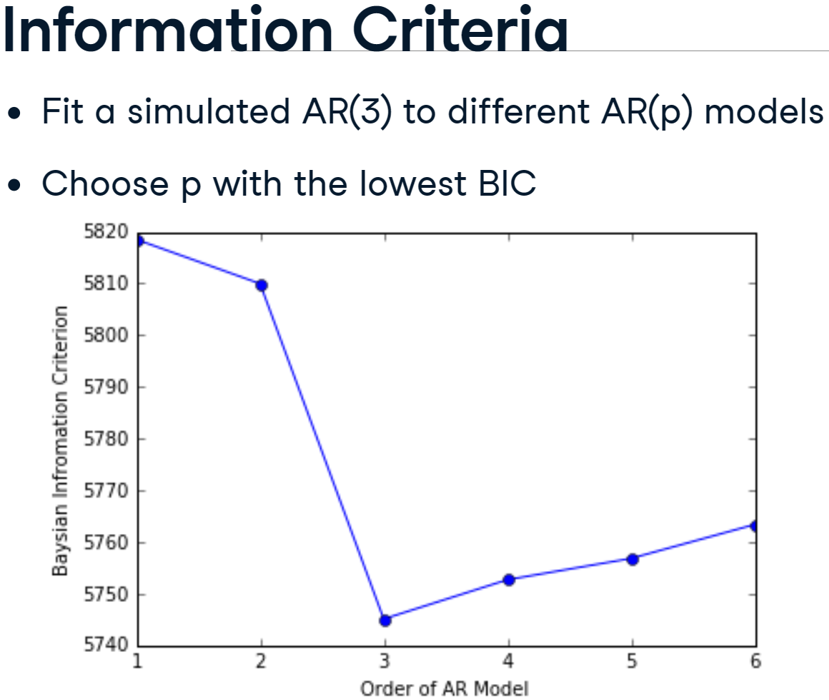

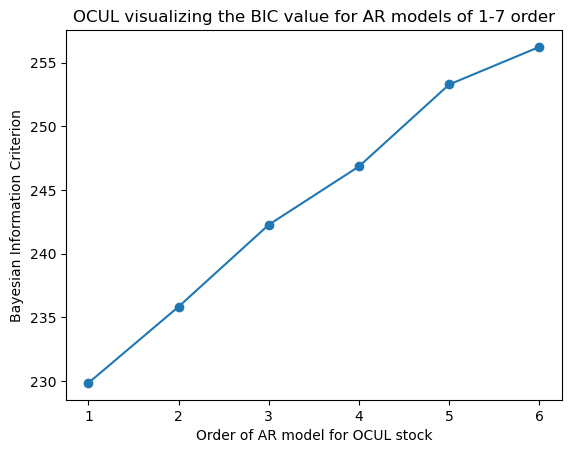

In [46]:
BIC = np.zeros(7)

for p in range(7):
    mod = ARIMA(df_3_daily['OCUL_Close'], order=(p,0,0))
    res = mod.fit(method_kwargs={'maxiter':100})
    # save BIC for AR(p)
    BIC[p] = res.bic
    
# plot the BIC as a function of p
plt.plot(range(1,7), BIC[1:7], marker='o')
plt.xlabel('Order of AR model for OCUL stock')
plt.ylabel('Bayesian Information Criterion')
plt.title("OCUL visualizing the BIC value for AR models of 1-7 order")
plt.show()


    -the BIC minimum for OCUL is reached at p=1, corresponding to an AR(1) model

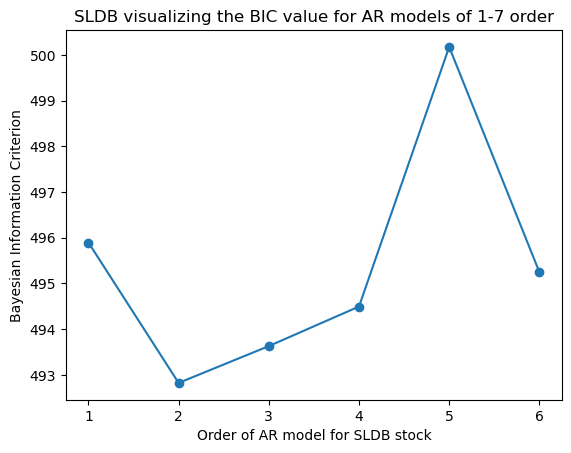

In [47]:
BIC = np.zeros(7)

for p in range(7):
    mod = ARIMA(df_3_daily['SLDB_Close'], order=(p,0,0))
    res = mod.fit(method_kwargs={'maxiter':100})
    # save BIC for AR(p)
    BIC[p] = res.bic
    
# plot the BIC as a function of p
plt.plot(range(1,7), BIC[1:7], marker='o')
plt.xlabel('Order of AR model for SLDB stock')
plt.ylabel('Bayesian Information Criterion')
plt.title("SLDB visualizing the BIC value for AR models of 1-7 order")
plt.show()

    -the BIC minimum for SLDB is reached at p=2, corresponding to an AR(2) model

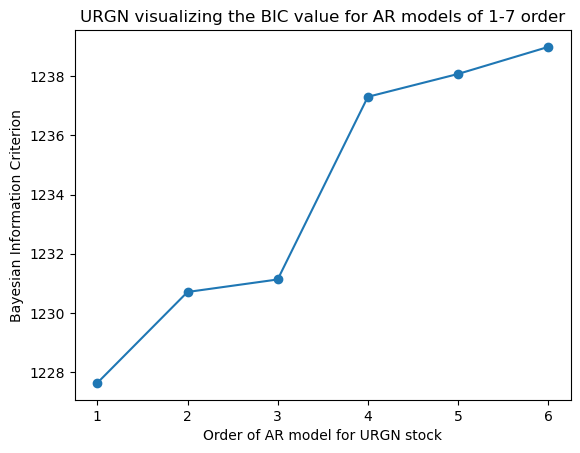

In [48]:
BIC = np.zeros(7)

for p in range(7):
    mod = ARIMA(df_3_daily['URGN_Close'], order=(p,0,0))
    res = mod.fit(method_kwargs={'maxiter':100})
    # save BIC for AR(p)
    BIC[p] = res.bic
    
# plot the BIC as a function of p
plt.plot(range(1,7), BIC[1:7], marker='o')
plt.xlabel('Order of AR model for URGN stock')
plt.ylabel('Bayesian Information Criterion')
plt.title("URGN visualizing the BIC value for AR models of 1-7 order")
plt.show()

    -the BIC minimum for URGN is reached at p=1, corresponding to an AR(1) model

# Moving Average Model - MA

In an **MA** model, today's value equals a mean plus noise, plus a fraction theta of yesterday's noise. Since there is only one lagged error on the right hand side, this is called an MA model of order 1, or simply an MA(1) model. If the MA parameter, theta, is zero, then the process is white noise. MA models are stationary for all values of theta.

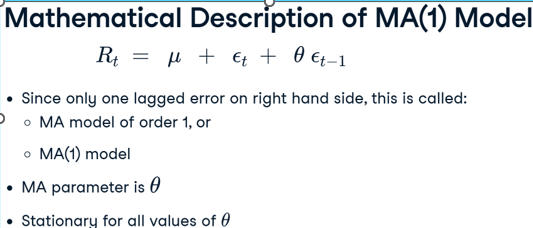

### The model can be extended to include more lagged errors and more theta parameters.

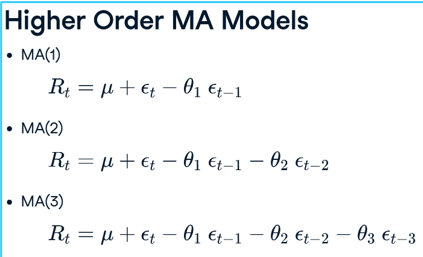

### Estimating an MA Model

The same module that I used to estimate the parameters of an AR model can be used to estimate the parameters of an MA model. 

Create an instance of that class called mod, with the arguments being the data that I'm trying to fit, and the order of the model. However, now the order is (0,0,1), for an MA(1), not (1,0,0) as it was for an AR(1). 

And as before with an AR model, once I instantiate the class, I then use the method fit to estimate the model, and store the results in result.

In [49]:
mod = ARIMA(df_3_daily['OCUL_Close'], order=(0,0,1))
result_MA_OCUL = mod.fit()
result_MA_OCUL.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             OCUL_Close   No. Observations:                  728
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -808.807
Date:                Fri, 26 Jul 2024   AIC                           1623.614
Time:                        20:09:41   BIC                           1637.385
Sample:                    07-26-2022   HQIC                          1628.928
                         - 07-22-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0042      0.090     55.684      0.000       4.828       5.180
ma.L1          0.9998    211.342      0.005      0.996    -413.222     415.222
sigma2         1.0266    216.941      0.005      0.996    -424.170     426.223
===================================================================================
Ljung-Box (L1) (Q):                 284.19   Jarque-Bera (JB):               523.80
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.51   Skew:                             1.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [50]:
mod = ARIMA(df_3_daily['SLDB_Close'], order=(0,0,1))
result_MA_SLDB = mod.fit()
result_MA_SLDB.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             SLDB_Close   No. Observations:                  728
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -1004.137
Date:                Fri, 26 Jul 2024   AIC                           2014.274
Time:                        20:09:41   BIC                           2028.044
Sample:                    07-26-2022   HQIC                          2019.587
                         - 07-22-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.6115      0.120     54.915      0.000       6.376       6.848
ma.L1          0.9951      8.259      0.120      0.904     -15.191      17.182
sigma2         2.2529     18.575      0.121      0.903     -34.153      38.659
===================================================================================
Ljung-Box (L1) (Q):                 305.17   Jarque-Bera (JB):               128.52
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.94   Skew:                             0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [51]:
mod = ARIMA(df_3_daily['URGN_Close'], order=(0,0,1))
result_MA_URGN = mod.fit()
result_MA_URGN.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             URGN_Close   No. Observations:                  728
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -1149.321
Date:                Fri, 26 Jul 2024   AIC                           2304.643
Time:                        20:09:42   BIC                           2318.413
Sample:                    07-26-2022   HQIC                          2309.956
                         - 07-22-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.4315      0.169     73.619      0.000      12.101      12.762
ma.L1          0.9997    111.804      0.009      0.993    -218.132     220.132
sigma2         4.0081    448.040      0.009      0.993    -874.133     882.150
===================================================================================
Ljung-Box (L1) (Q):                 257.06   Jarque-Bera (JB):               138.64
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             0.77
Prob(H) (two-sided):                  0.20   Kurtosis:                         4.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Forecasting an MA model

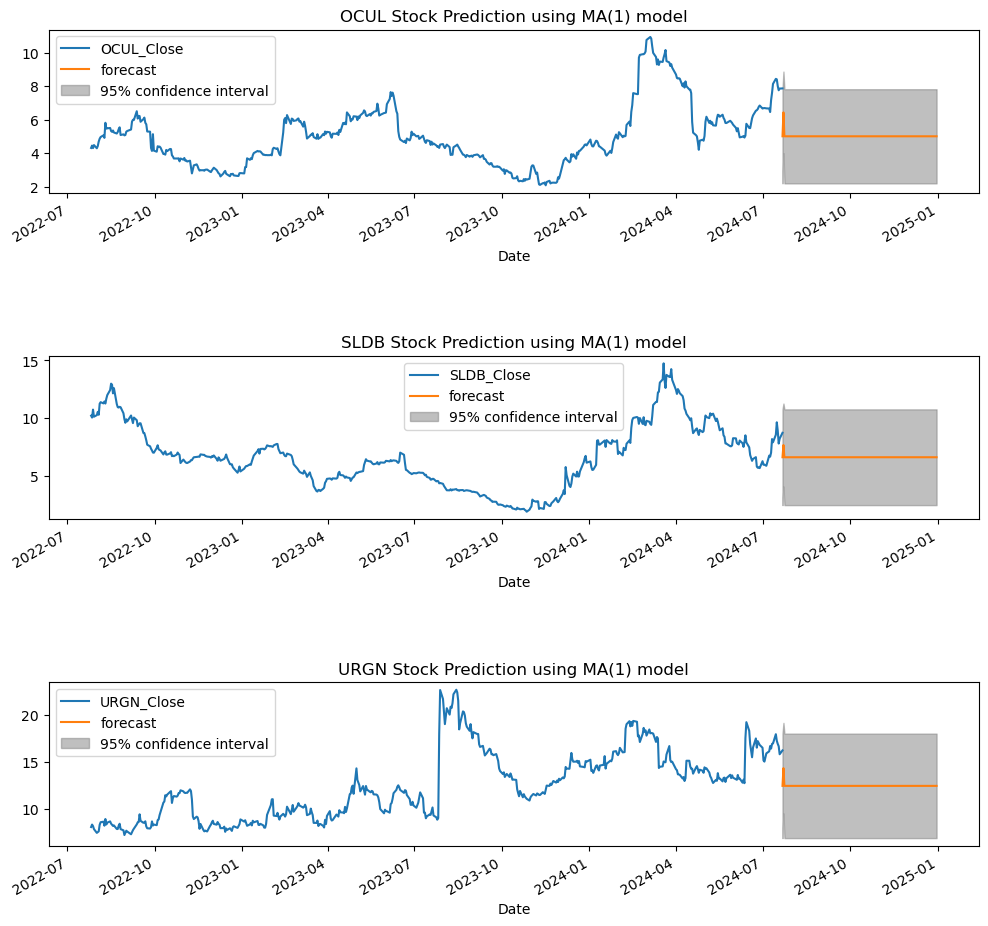

In [52]:
# Create a 1x3 grid of subplots for Stock prediction


fig, axes = plt.subplots(3,1, figsize = (12,12), gridspec_kw={'wspace': 1, 'hspace': 1})


fig= df_3['OCUL_Close'].plot(ax=axes[0])
fig=plot_predict(result_MA_OCUL, start='2024-07-22', end='2024-12-31', ax=axes[0])
axes[0].set_title('OCUL Stock Prediction using MA(1) model')

fig=df_3['SLDB_Close'].plot(ax=axes[1])
fig=plot_predict(result_MA_SLDB, start='2024-07-22', end='2024-12-31', ax=axes[1])
axes[1].set_title('SLDB Stock Prediction using MA(1) model')

fig=df_3['URGN_Close'].plot(ax=axes[2])
fig=plot_predict(result_MA_URGN, start='2024-07-22', end='2024-12-31', ax=axes[2])
axes[2].set_title('URGN Stock Prediction using MA(1) model')


plt.show()

    -Notice the out-of-sample forecasts are flat into the future after the first data point

### Estimating an MA model

In [53]:
mod = ARIMA(df_3_daily['OCUL_Close'], order=(0,0,1))
result_MA_OCUL = mod.fit()
result_MA_OCUL.params[1]  # the theta parameter

0.9998306748593507

# ARMA models

An ARMA model is a combination of an AR and MA model. Here is the formula for an ARMA(1,1) model, which has the familiar AR(1) and MA(1) components

an AR(1) model is equivalent to an MA(∞) model with the appropriate parameters

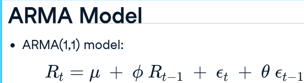

Higher frequency stock data is well modeled by an MA(1) process, say at a frequency of one minute

# Train-test split

In [54]:
df_train_OCUL = df_OCUL['OCUL_Close'].loc[:'2023']
df_test_OCUL = df_OCUL['OCUL_Close'].loc['2024':]
print(df_train_OCUL.head())
print(df_test_OCUL.head())

Date
2022-07-25    4.26
2022-07-26    4.31
2022-07-27    4.45
2022-07-28    4.30
2022-07-29    4.48
Name: OCUL_Close, dtype: float64
Date
2024-01-02    4.81
2024-01-03    4.54
2024-01-04    4.41
2024-01-05    4.40
2024-01-08    4.74
Name: OCUL_Close, dtype: float64


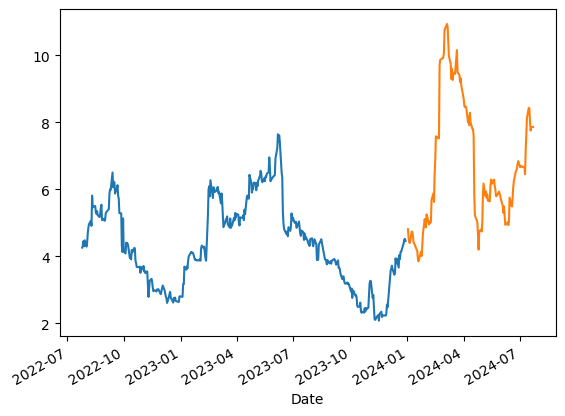

In [55]:
fig, ax = plt.subplots()

df_train_OCUL.plot(ax=ax)
df_test_OCUL.plot(ax=ax)
plt.show()

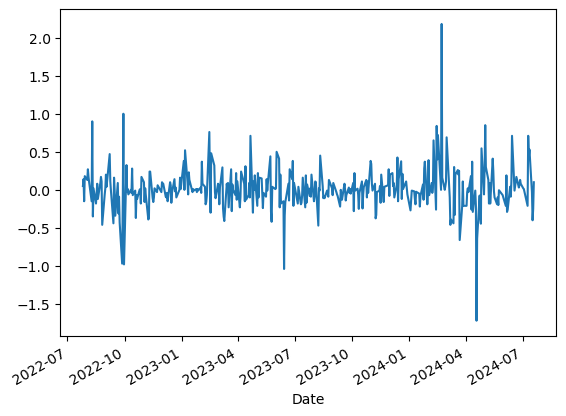

In [56]:
df_OCUL_daily = df_OCUL.resample(rule='D').last()
df_OCUL_stationary = df_OCUL_daily['OCUL_Close'].diff().dropna()
df_OCUL_stationary.plot()
plt.show()  # it is stationary now

In [57]:
print(type(df_OCUL_stationary))

<class 'pandas.core.series.Series'>


An ARMA model is a combination of the AR and MA models. The time series is regressed on the previous values and the previous shock terms. This is an ARMA(1,1) model. More generally we use ARMA(p,q) to define an ARMA model. 

The **p** tells us the order of the *autoregressive* part of the model and the **q** tells us the order of the *moving-average* part.

In [58]:
model_ARIMA_OCUL= ARIMA(df_3_daily['OCUL_Close'], order=(2,0,1))
result_ARIMA_OCUL = model_ARIMA_OCUL.fit()

result_ARIMA_OCUL.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             OCUL_Close   No. Observations:                  728
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -104.671
Date:                Fri, 26 Jul 2024   AIC                            219.343
Time:                        20:09:43   BIC                            242.294
Sample:                    07-26-2022   HQIC                           228.199
                         - 07-22-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2322      1.159      4.513      0.000       2.960       7.504
ar.L1         -0.0036      0.040     -0.091      0.927      -0.082       0.074
ar.L2          0.9832      0.035     28.012      0.000       0.914       1.052
ma.L1          0.9999      1.077      0.929      0.353      -1.110       3.110
sigma2         0.0693      0.073      0.945      0.345      -0.074       0.213
===================================================================================
Ljung-Box (L1) (Q):                   2.92   Jarque-Bera (JB):             14700.03
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                             1.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Predict the next value

One-step-ahead predictions:

In the time period we have data for, we can make lots of these predictions in-sample; using the previous series value to estimate the next ones. This is called a one-step-ahead prediction. This allows us to evaluate how good our model is at predicting just one value ahead. 

We can use a fitted ARIMA model to make these predictions. Starting from a ARIMA fitted results object, we can use its get_prediction method to generate in sample predictions. 

We set the start parameter as a negative integer stating how many steps back to begin the forecast. Setting start to -25 means we make predictions for the last 25 entries of the training data

In [59]:
# Make predictions for last 30 values
model_ARIMA_OCUL= ARIMA(df_3_daily['OCUL_Close'], order=(2,0,1))
result_ARIMA_OCUL = model_ARIMA_OCUL.fit()

# Make in-sample prediction

forecast_OCUL = result_ARIMA_OCUL.get_prediction(start = -30)

# forecast mean

mean_forecast_OCUL = forecast_OCUL.predicted_mean
mean_forecast_OCUL

Date
2024-06-23    6.229182
2024-06-24    6.225502
2024-06-25    6.510568
2024-06-26    6.552630
2024-06-27    6.609735
2024-06-28    6.750788
2024-06-29    6.817417
2024-06-30    6.807174
2024-07-01    6.785008
2024-07-02    6.651126
2024-07-03    6.659501
2024-07-04    6.680749
2024-07-05    6.660196
2024-07-06    6.660879
2024-07-07    6.640605
2024-07-08    6.631711
2024-07-09    6.639846
2024-07-10    6.442198
2024-07-11    7.138389
2024-07-12    7.579331
2024-07-13    8.098825
2024-07-14    8.070802
2024-07-15    8.040253
2024-07-16    8.399077
2024-07-17    8.365577
2024-07-18    7.972006
2024-07-19    7.722838
2024-07-20    7.824930
2024-07-21    7.796510
2024-07-22    7.771965
Freq: D, Name: predicted_mean, dtype: float64

### Confidence intervals

In [60]:
confidence_intervals_OCUL = forecast_OCUL.conf_int()
confidence_intervals_OCUL

,lower OCUL_Close,upper OCUL_Close
Date,,
2024-06-23,5.500971,6.957392
2024-06-24,5.338765,7.112239
2024-06-25,5.994026,7.027110
2024-06-26,6.036089,7.069170
2024-06-27,6.093197,7.126274
2024-06-28,6.234251,7.267325
2024-06-29,6.300882,7.333952
2024-06-30,6.078963,7.535385
2024-07-01,5.898272,7.671744


In [61]:
print(type(confidence_intervals_OCUL))

<class 'pandas.core.frame.DataFrame'>


In [62]:
confidence_intervals_OCUL.columns

Index(['lower OCUL_Close', 'upper OCUL_Close'], dtype='object')

### Plotting predictions

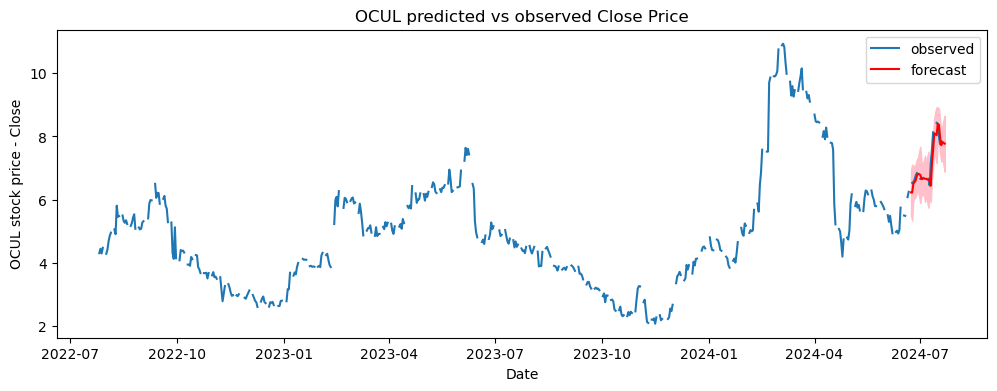

In [63]:
lower_limits = confidence_intervals_OCUL.loc[:,'lower OCUL_Close']
upper_limits = confidence_intervals_OCUL.loc[:,'upper OCUL_Close']

fig, axes = plt.subplots(figsize = (12,4))
# plot the OCUL Close data
plt.plot(df_3_daily.index, df_3_daily['OCUL_Close'], label='observed')

# Plot the mean predictions
plt.plot(mean_forecast_OCUL.index, mean_forecast_OCUL, color='r', label ='forecast')

# shade the area between the confidence limits
plt.fill_between(confidence_intervals_OCUL.index, lower_limits, upper_limits, color='pink')

# set labels, legends and show plot

plt.xlabel('Date')
plt.ylabel('OCUL stock price - Close')
plt.title('OCUL predicted vs observed Close Price')
plt.legend()
plt.show()


### Making dynamic predictions

The only difference is that in the get-predictions method, we set the parameter dynamic equals true. Everything else is exactly as before.

In [64]:
# Make predictions for last 30 values
model_ARIMA_OCUL= ARIMA(df_3_daily['OCUL_Close'], order=(2,0,1))
result_ARIMA_OCUL = model_ARIMA_OCUL.fit()

# Make in-sample prediction

forecast_OCUL_dynamic = result_ARIMA_OCUL.get_prediction(start = -30, dynamic=True)

# forecast mean

mean_forecast_dyn_OCUL = forecast_OCUL_dynamic.predicted_mean

mean_forecast_dyn_OCUL

Date
2024-06-23    6.229182
2024-06-24    6.225502
2024-06-25    6.208789
2024-06-26    6.205232
2024-06-27    6.188813
2024-06-28    6.185376
2024-06-29    6.169246
2024-06-30    6.165925
2024-07-01    6.150079
2024-07-02    6.146871
2024-07-03    6.131304
2024-07-04    6.128206
2024-07-05    6.112912
2024-07-06    6.109923
2024-07-07    6.094897
2024-07-08    6.092012
2024-07-09    6.077250
2024-07-10    6.074467
2024-07-11    6.059964
2024-07-12    6.057281
2024-07-13    6.043031
2024-07-14    6.040445
2024-07-15    6.026445
2024-07-16    6.023953
2024-07-17    6.010197
2024-07-18    6.007797
2024-07-19    5.994282
2024-07-20    5.991972
2024-07-21    5.978692
2024-07-22    5.976469
Freq: D, Name: predicted_mean, dtype: float64

In [65]:
# get confidence intervals of forecasts
confidence_intervals_dyn_OCUL = forecast_OCUL_dynamic.conf_int()
confidence_intervals_dyn_OCUL


,lower OCUL_Close,upper OCUL_Close
Date,,
2024-06-23,5.500971,6.957392
2024-06-24,5.338765,7.112239
2024-06-25,5.189410,7.228169
2024-06-26,5.071748,7.338715
2024-06-27,4.952934,7.424693
2024-06-28,4.857555,7.513196
2024-06-29,4.756477,7.582015
2024-06-30,4.675259,7.656590
2024-07-01,4.586275,7.713883


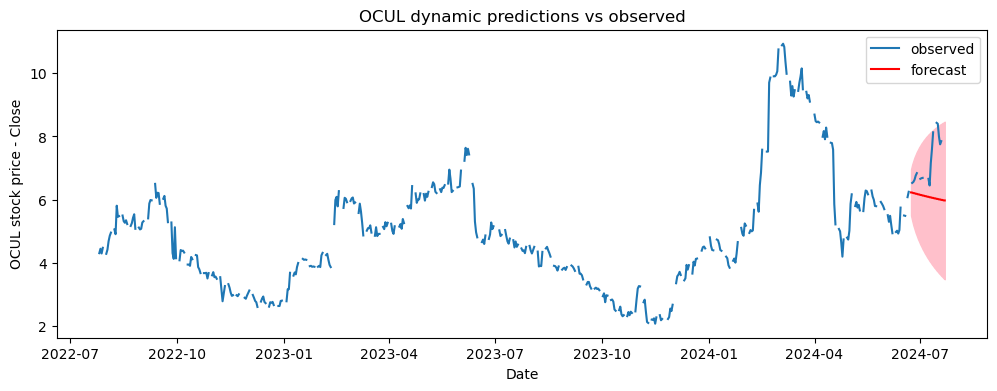

In [66]:
lower_limits_dyn = confidence_intervals_dyn_OCUL.loc[:,'lower OCUL_Close']
upper_limits_dyn = confidence_intervals_dyn_OCUL.loc[:,'upper OCUL_Close']

fig, axes = plt.subplots(figsize = (12,4))
# plot the OCUL Close data
plt.plot(df_3_daily.index, df_3_daily['OCUL_Close'], label='observed')

# Plot the mean predictions
plt.plot(mean_forecast_dyn_OCUL.index, mean_forecast_dyn_OCUL, color='r', label ='forecast')

# shade the area between the confidence limits
plt.fill_between(confidence_intervals_dyn_OCUL.index, lower_limits_dyn, upper_limits_dyn, color='pink')

# set labels, legends and show plot

plt.xlabel('Date')
plt.ylabel('OCUL stock price - Close')
plt.title('OCUL dynamic predictions vs observed')
plt.legend()
plt.show()

# Forecasting out of sample

Finally, after testing our predictions in-sample, we can use our model to predict the future. To make future forecasts we use the get_forecast method of the results object. We choose the number of steps after the end of the training data to forecast up to. Everything else neatly follows as before.

In [67]:
# Make predictions for future 20 values
model_ARIMA_OCUL= ARIMA(df_3_daily['OCUL_Close'], order=(2,1,1))
result_ARIMA_future_OCUL = model_ARIMA_OCUL.fit()

# Make in-sample prediction

forecast_future_OCUL = result_ARIMA_future_OCUL.get_forecast(steps = 20)

# forecast mean

mean_forecast_future_OCUL = forecast_future_OCUL.predicted_mean
mean_forecast_future_OCUL

2024-07-23    7.862539
2024-07-24    7.864982
2024-07-25    7.867110
2024-07-26    7.868980
2024-07-27    7.870624
2024-07-28    7.872068
2024-07-29    7.873336
2024-07-30    7.874450
2024-07-31    7.875429
2024-08-01    7.876290
2024-08-02    7.877045
2024-08-03    7.877709
2024-08-04    7.878292
2024-08-05    7.878805
2024-08-06    7.879255
2024-08-07    7.879650
2024-08-08    7.879998
2024-08-09    7.880303
2024-08-10    7.880571
2024-08-11    7.880807
Freq: D, Name: predicted_mean, dtype: float64

### The model order is very important to the quality of forecasts. 

Here we have fit different models to the same dataset and then made forecasts using each. The mean predictions of the forecasts are shown as orange lines and you can see that they are very different.

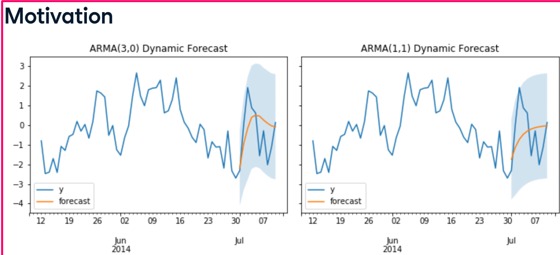

One of the main ways to identify the correct model order is by using the autocorrelation function, the ACF, and the partial autocorrelation function the PACF.

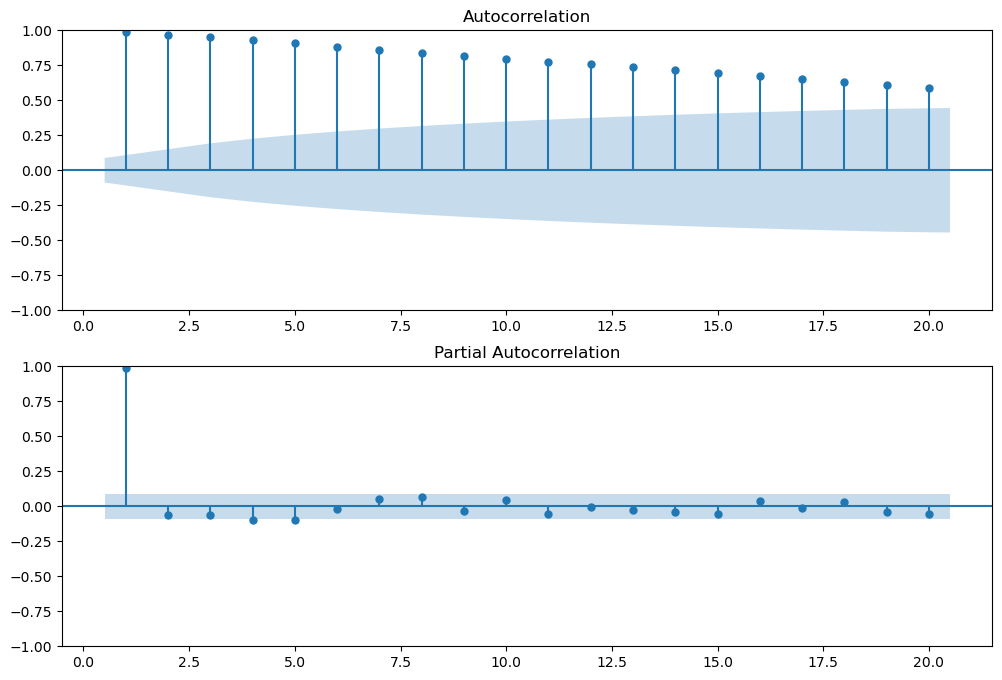

In [68]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize = (12,8))

# Plot the ACF of df_3['OCUL_Close']
plot_acf(df_3['OCUL_Close'], lags=20, zero=False, ax=ax1)

# Plot the PF of df_3_daily['OCUL_Close']
plot_pacf(df_3['OCUL_Close'], lags=20, zero=False, ax=ax2)

plt.show()


    -If the ACF values are high and tail off very very slowly this is a sign that the data is non-stationarity, so it needs to be differenced.

In [69]:
# use the stationary df of OCUL

df_OCUL_stationary

Date
2022-07-26    0.050000
2022-07-27    0.140000
2022-07-28   -0.150000
2022-07-29    0.180000
2022-08-02    0.130000
                ...   
2024-07-12    0.530000
2024-07-16   -0.030001
2024-07-17   -0.400000
2024-07-18   -0.250000
2024-07-19    0.100000
Name: OCUL_Close, Length: 391, dtype: float64

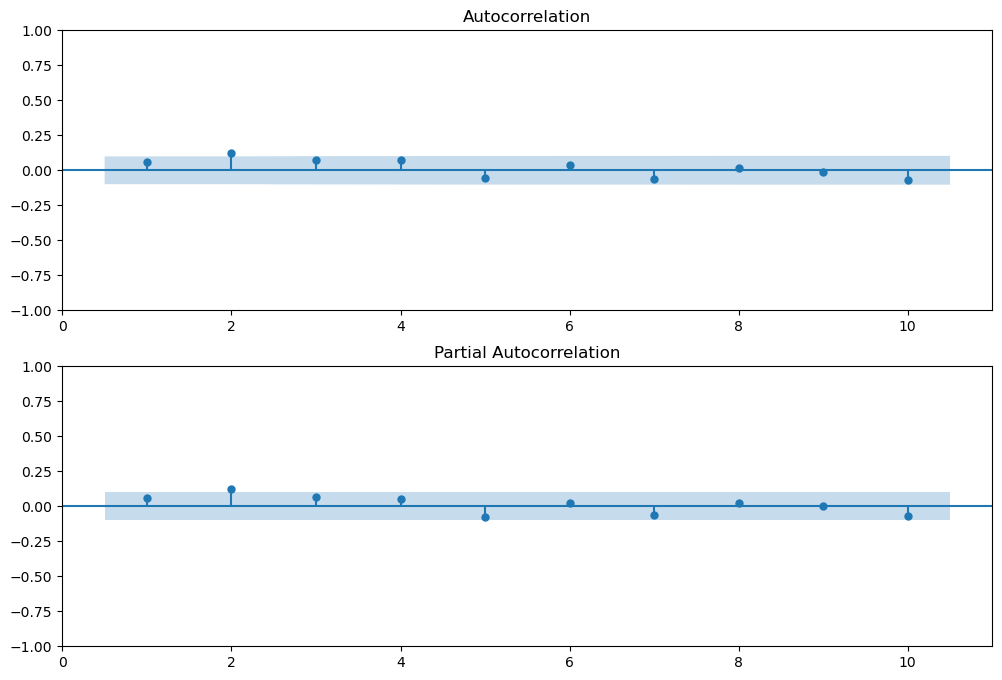

In [70]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize = (12,8))

# Plot the ACF of df_3['OCUL_Close']
plot_acf(df_OCUL_stationary, lags=10, zero=False, ax=ax1)

# Plot the PF of df_3_daily['OCUL_Close']
plot_pacf(df_OCUL_stationary, lags=10, zero=False, ax=ax2)

plt.show()

    -By comparing the ACF and PACF for a time series we can deduce the model order. 
    -If the amplitude of the ACF tails off with increasing lag and the PACF cuts off after some lag p, then we have a AR(p) model.

**For OCUL data, the amplitude of the ACF cuts offafter lag 2 so it's a MA(2) model, and the PACF tails off.**

**Based on ACF and PACF plots, the model for OCUL data is MA(2)** 

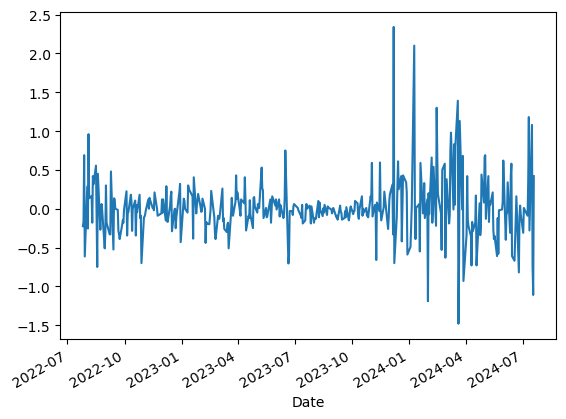

In [71]:
df_SLDB_daily = df_SLDB.resample(rule='D').last()
df_SLDB_stationary = df_SLDB_daily['SLDB_Close'].diff().dropna()
df_SLDB_stationary.plot()
plt.show()  # it is stationary now

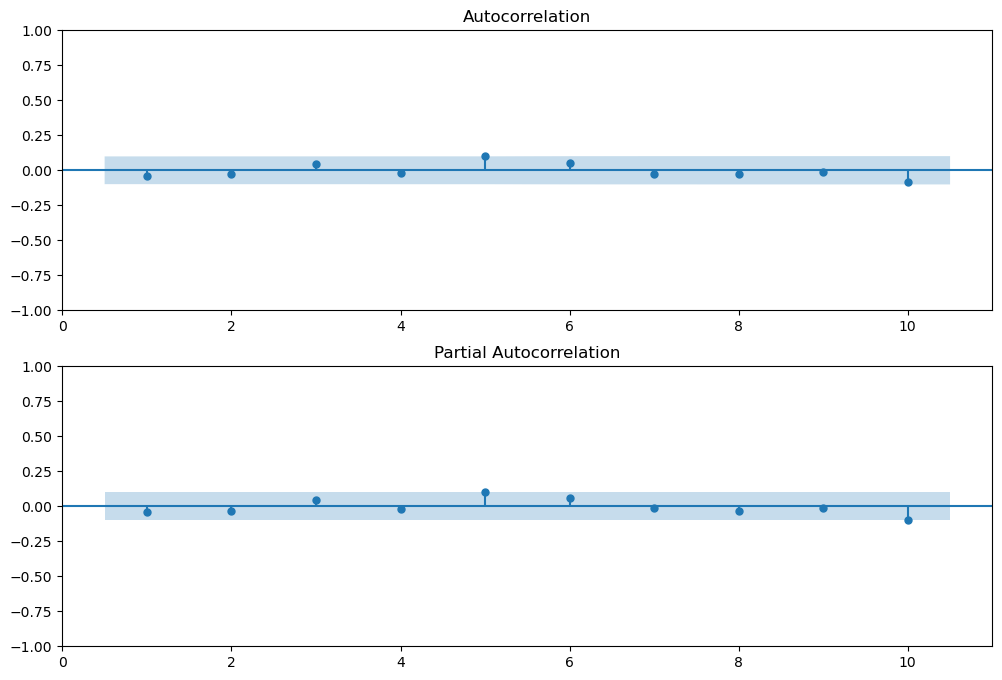

In [72]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize = (12,8))

# Plot the ACF of df_3['OCUL_Close']
plot_acf(df_SLDB_stationary, lags=10, zero=False, ax=ax1)

# Plot the PF of df_3_daily['OCUL_Close']
plot_pacf(df_SLDB_stationary, lags=10, zero=False, ax=ax2)

plt.show()

**For SLDB data, the amplitude of the ACF cuts offafter lag 5 so it's a MA(5) model, and the PACF tails off.**

**Based on ACF and PACF plots, the model for SLDB data is MA(5)** 

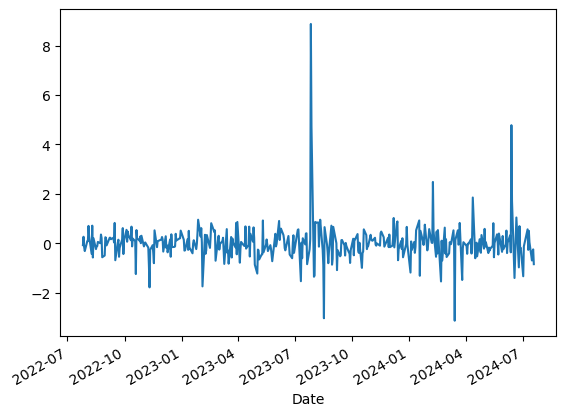

In [73]:
df_URGN_daily = df_URGN.resample(rule='D').last()
df_URGN_stationary = df_URGN_daily['URGN_Close'].diff().dropna()
df_URGN_stationary.plot()
plt.show()  # it is stationary now

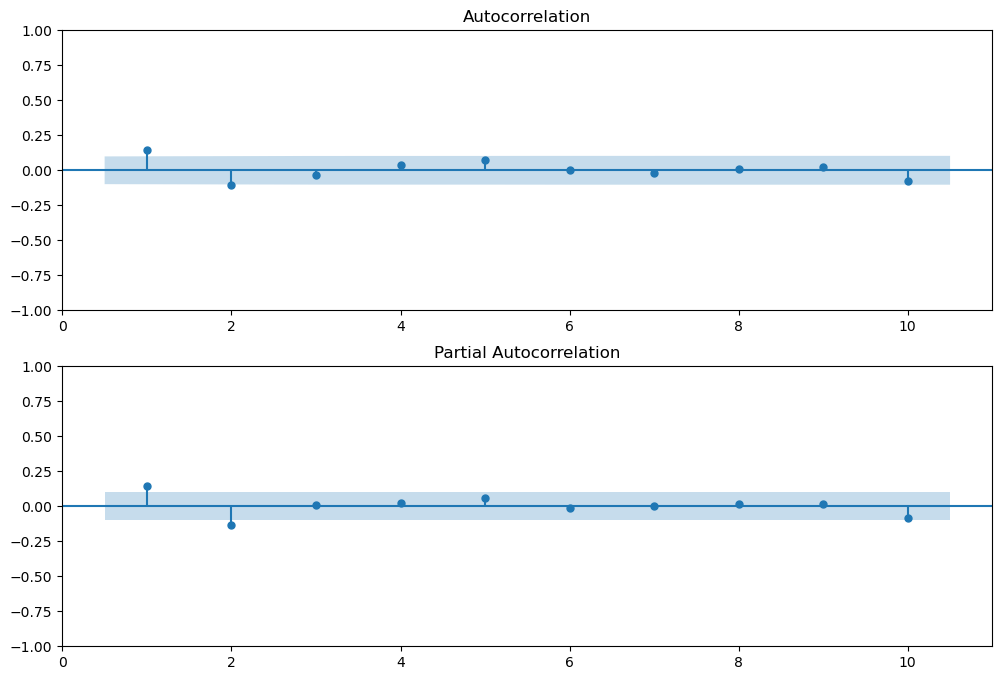

In [74]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize = (12,8))

# Plot the ACF of df_3['OCUL_Close']
plot_acf(df_URGN_stationary, lags=10, zero=False, ax=ax1)

# Plot the PF of df_3_daily['OCUL_Close']
plot_pacf(df_URGN_stationary, lags=10, zero=False, ax=ax2)

plt.show()

**For URGN data, the amplitude of the PACF cuts offafter lag 2 so it's a AR(2) model, and the ACF tails off.**

**Based on ACF and PACF plots, the model for SLDB data is AR(2)** 

# Model Diagnostic

To diagnose our model we focus on the residuals to the training data. The residuals are the difference between the our model's one-step-ahead predictions and the real values of the time series.

In [91]:
# Make predictions for future 20 values
model_ARIMA_OCUL= ARIMA(df_3_daily['OCUL_Close'], order=(1,1,1))
result_ARIMA_OCUL = model_ARIMA_OCUL.fit()

# Assign residuals to variable
residuals_OCUL = result_ARIMA_OCUL.resid
residuals_OCUL


Date
2022-07-26    4.310000
2022-07-27    0.140000
2022-07-28   -0.152137
2022-07-29    0.180313
2022-07-30         NaN
                ...   
2024-07-18   -0.260589
2024-07-19    0.093863
2024-07-20         NaN
2024-07-21         NaN
2024-07-22   -0.009441
Freq: D, Length: 728, dtype: float64

We want to know, on average, how large the residuals are and so how far our predictions are from the true values. To answer this we can calculate the mean absolute error of the residuals.

In [92]:
mae = np.mean(np.abs(residuals_OCUL))
mae

0.18973246069471034

### Plot Diagnostics

For an ideal model the residuals should be uncorrelated white Gaussian noise centered on zero.

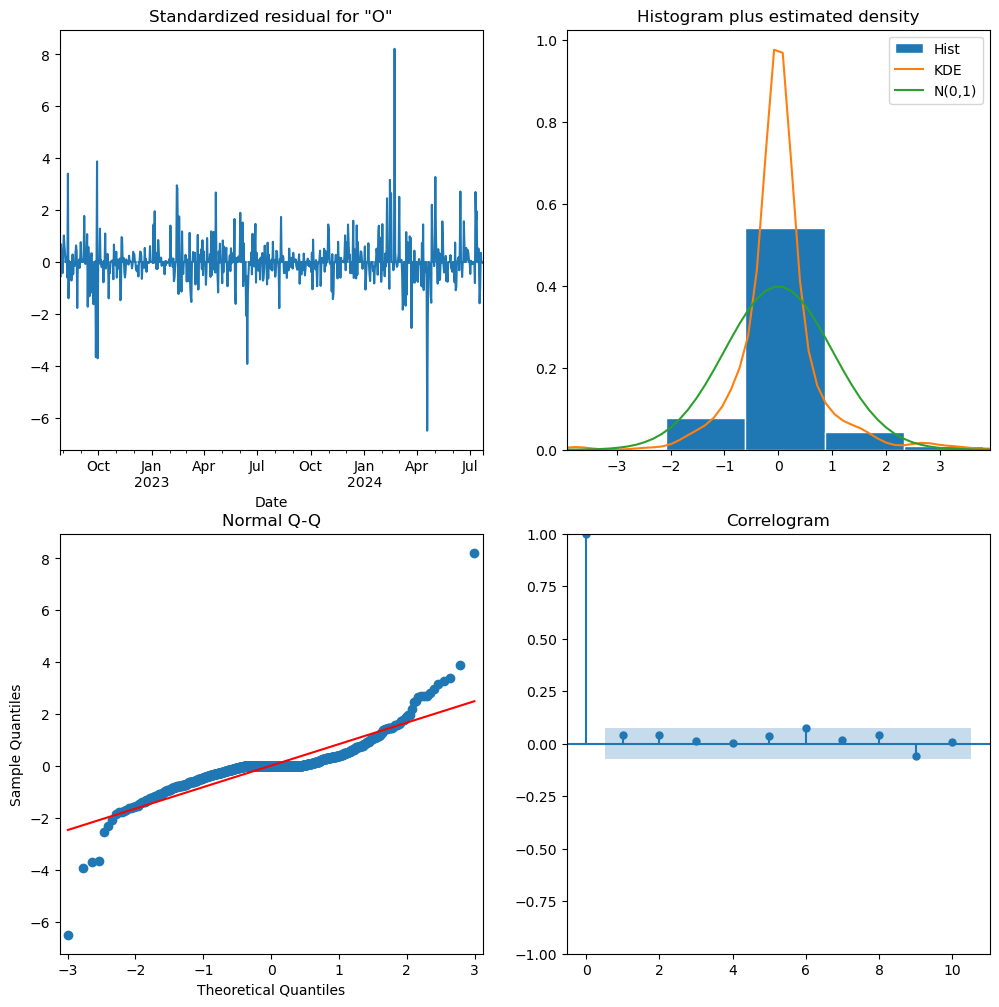

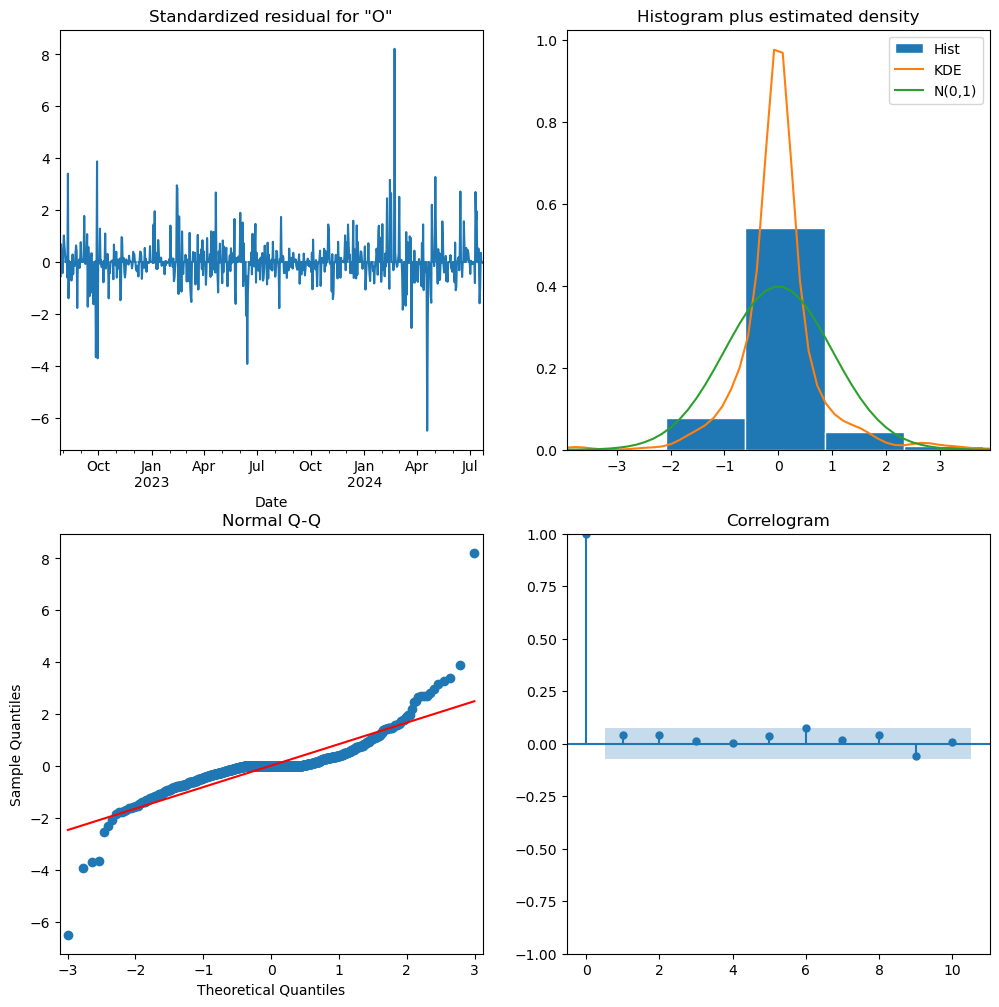

In [93]:
result_ARIMA_OCUL.plot_diagnostics(figsize = (12,12))

The **histogram** shows us the measured distribution; the orange line shows a smoothed version of this histogram; and the green line, shows a normal distribution. If our model is good these two lines should be almost the same. 

The **normal Q-Q** plot is another way to show how the distribution of the model residuals compares to a normal distribution. If our residuals are normally distributed then all the points should lie along the red line, except perhaps some values at either end.

The last plot is the **correlogram**, which is just an ACF plot of the residuals rather than the data. 95% of the correlations for lag greater than zero should not be significant. If there is significant correlation in the residuals, it means that there is information in the data that our model hasn't captured.

In [94]:
print(result_ARIMA_OCUL.summary())

                               SARIMAX Results                                
Dep. Variable:             OCUL_Close   No. Observations:                  728
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -104.353
Date:                Fri, 26 Jul 2024   AIC                            214.705
Time:                        20:11:23   BIC                            228.472
Sample:                    07-26-2022   HQIC                           220.018
                         - 07-22-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9249      0.158      5.836      0.000       0.614       1.235
ma.L1         -0.9108      0.173     -5.275      0.000      -1.249      -0.572
sigma2         0.0692      0.002     37.153      0.0

**Prob(Q)** is 0.24,  is the p-value associated with the null hypothesis that the residuals have no correlation structure

**Prob(JB)** is 0, is the p-value associated with the null hypothesis that the residuals are Gaussian normally distributed. 

If either p-value is less than 0.05 we reject that hypothesis.

Prob(Q) indicates Residuals are not correlated and are normally distributed